In [1]:
import pandas, numpy, seaborn, umap
import sklearn, sklearn.manifold, sklearn.preprocessing

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4)})
from  sklearn.decomposition import  PCA
from scipy.stats import entropy
import scipy.stats

# 0. user-defined data

In [2]:
# files should not have spaces
optimal_data_set_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset.csv' 
optimal_data_set_names_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset_list.csv'
metadata_folder = '/Users/farhadzare/Desktop/Endothelium/metadata/'

# 1. read data & metadata

## 1.1. read data

In [4]:
# restrict df to generic temporal variables. Use variable names that reflect their contents
expression = pandas.read_csv(optimal_data_set_file)
#expression.drop(["Unnamed: 0"], axis='columns', inplace=True)
expression = expression.set_index("Feature")
expression.rename_axis(None, inplace=True)

print(expression.shape)
expression.head()

(4998, 2636)


,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46386.CEL,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL
100,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.277586,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925
1000,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.676218,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392
10000,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.441616,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776
10005,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.281914,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195
10006,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.486721,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073


In [5]:
transpose_expression = expression.transpose()
transpose_expression.head()

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
E-GEOD-30169_GSM752709.cel,6.082276,8.910453,3.903745,5.963907,7.752008,7.375102,5.187760,5.620045,10.513556,9.541779,...,9.972469,11.040979,7.934275,10.396367,7.174313,9.607231,4.541300,5.560324,5.421064,6.115885
E-GEOD-30169_GSM752710.cel,6.296477,9.094440,3.573659,6.097107,7.465366,7.314584,4.776528,5.593111,10.304974,9.013600,...,9.869174,11.418171,8.313562,10.662624,6.760496,9.543961,4.129266,5.308262,5.107210,5.385675
E-GEOD-30169_GSM752711.cel,5.678143,9.018398,3.750108,5.790247,7.941747,7.420180,5.657152,5.238865,10.533208,9.677985,...,9.908754,11.222550,7.915767,10.335600,7.501811,9.677517,4.073877,5.546625,5.445133,5.948111
E-GEOD-30169_GSM752712.cel,5.903716,8.981716,4.090731,5.761399,7.606796,7.501158,5.115412,5.331495,10.522132,9.546220,...,9.884071,11.050198,7.927955,10.168285,7.240025,9.559407,4.563461,5.734750,5.229923,5.777848
E-GEOD-30169_GSM752713.cel,6.561618,9.903595,3.960562,6.016096,7.469340,7.443952,5.041231,5.256271,10.415659,9.294982,...,9.883845,9.632507,8.109991,10.208548,6.728994,9.398856,3.990184,5.004711,5.538198,5.569191


## 1.2. read metadata

Samples will be colored according to organ of origin, as defined in metadata files.

In [6]:
# get working studies
df = pandas.read_csv(optimal_data_set_names_file)
working_studies_data_files = df.iloc[:, -1].to_list()
print(len(working_studies_data_files), working_studies_data_files[:5])

working_studies_metadata_files = [element.replace('data', 'metadata') for element in working_studies_data_files]
print(len(working_studies_metadata_files), working_studies_metadata_files[:5])


168 ['E-GEOD-30169 data.csv', 'E-GEOD-5883 data.csv', 'E-GEOD-3920 data.csv', 'E-GEOD-5556 data.csv', 'E-GEOD-69996 data.csv']
168 ['E-GEOD-30169 metadata.csv', 'E-GEOD-5883 metadata.csv', 'E-GEOD-3920 metadata.csv', 'E-GEOD-5556 metadata.csv', 'E-GEOD-69996 metadata.csv']


In [7]:
# read tissue of origin
tissues_of_origin = []
for element in working_studies_metadata_files:
    file = metadata_folder + element
    df = pandas.read_csv(file, encoding='latin1')
    
    # check that species is human
    species = list(set(df['Species'].to_list()))
    if species != ['Homo sapiens']:
        print('ERROR about species')
        
    # get tissue of origin for this study
    tissue_of_origin = df['Organ'].to_list()
    for element in tissue_of_origin:
        tissues_of_origin.append(element)
    
# checking number of metadata elements
print(len(tissues_of_origin))

2636


In [8]:
# bring to "Other" if tissue of origin in less common than n samples
threshold = 10 # a threshold of 10 provides 20 groups which is perfect for tab20
unfrequent_tissues = []
unique_tissues = list(set(tissues_of_origin))
for element in unique_tissues:
    if tissues_of_origin.count(element) < threshold:
        unfrequent_tissues.append(element)

for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i] in unfrequent_tissues:
        tissues_of_origin[i] = 'Other'
        
# checking frequencies
unique_tissues = list(set(tissues_of_origin))
for i in range(len(unique_tissues)):
    print(i, unique_tissues[i], tissues_of_origin.count(unique_tissues[i]))

0 Other 34
1 Liver 84
2 Uterus 10
3 Umbilical cord blood 41
4 Umbilical cord 887
5 Lung 157
6 Somatic cell hybrid 12
7 Blood vessel 12
8 Skin 113
9 Eye 50
10 Heart 164
11 Aorta 723
12 Intestine 48
13 Kidney 14
14 Bone 43
15 Peripheral blood 24
16 Placenta 19
17 Blood 140
18 Lymphatic system 27
19 Brain 34


In [10]:
# compute colors
tissue_ranks = [unique_tissues.index(element) for element in tissues_of_origin]

# checking
print('checking...')
for i in range(len(list(set(tissue_ranks)))):
    print(i, tissue_ranks.count(i))

# mapping
my_map = matplotlib.cm.get_cmap('tab20')
working_colors = my_map(tissue_ranks)

checking...
0 34
1 84
2 10
3 41
4 887
5 157
6 12
7 12
8 113
9 50
10 164
11 723
12 48
13 14
14 43
15 24
16 19
17 140
18 27
19 34


# 2. quantile normalization

## 2.1. visualize raw data

In [11]:
# check the max and min of some rows and columns
# random gene
print(numpy.min(expression.loc[100]), numpy.max(expression.loc[100]))
# first sample
print(numpy.min(expression.iloc[:, 0]), numpy.max(expression.iloc[:, 0]))

-0.273055864480856 14.9369277370231
2.92495441874382 13.4211736028108


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


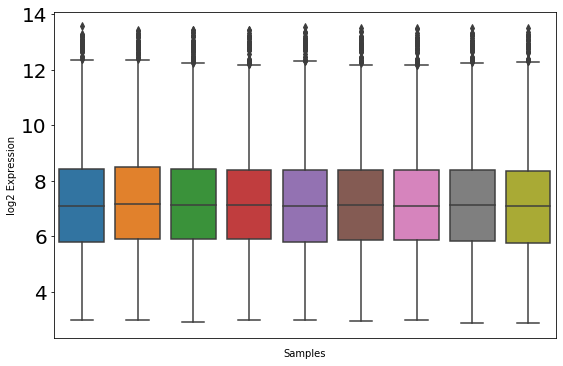

In [10]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:10], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

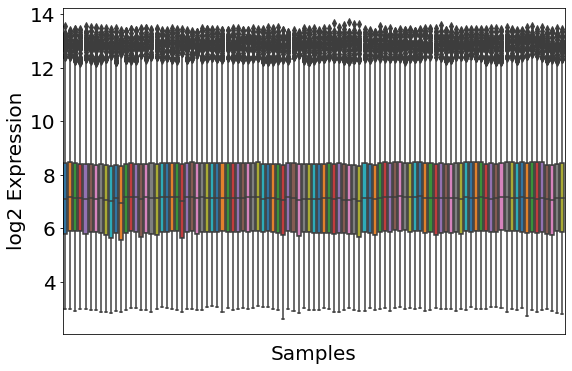

In [11]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:100], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

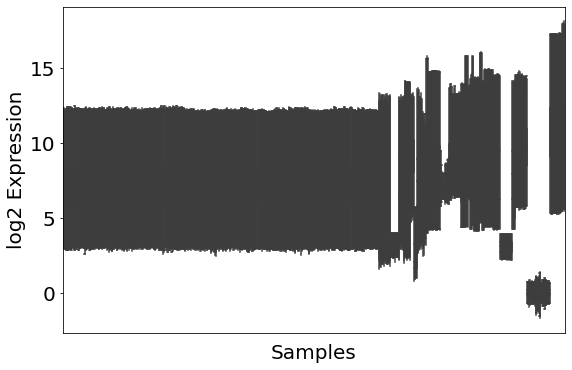

In [12]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:1000], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()


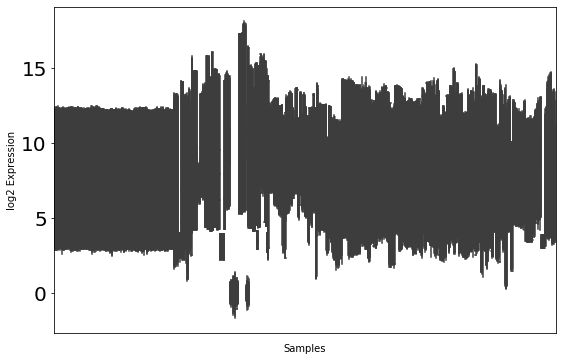

CPU times: user 2min 18s, sys: 808 ms, total: 2min 18s
Wall time: 2min 19s


<Figure size 432x288 with 0 Axes>

In [16]:
%%time
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression.iloc[:, 1:expression.shape[1]], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('sample_experssion_in_log2.jpg')

## 2.2. quantile normalization

In [13]:
def quantile_normalization(df):
    
    "Quantile normalization consists on sorting, averaging and re-ordering."
    "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
    # step 1/3: sorting sample values
    df_sorted = pandas.DataFrame(numpy.sort(df.values, axis=0), index=df.index, columns=df.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = numpy.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df.rank(method="min").astype(int)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

    return df_qn

In [14]:
%%time
expression_qn = quantile_normalization(expression)

CPU times: user 4.75 s, sys: 1.22 s, total: 5.97 s
Wall time: 6.13 s


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


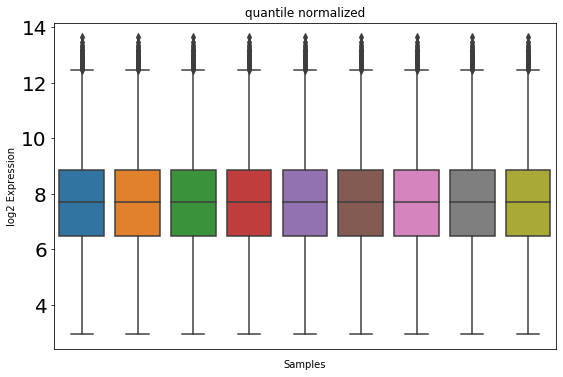

In [13]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:10], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

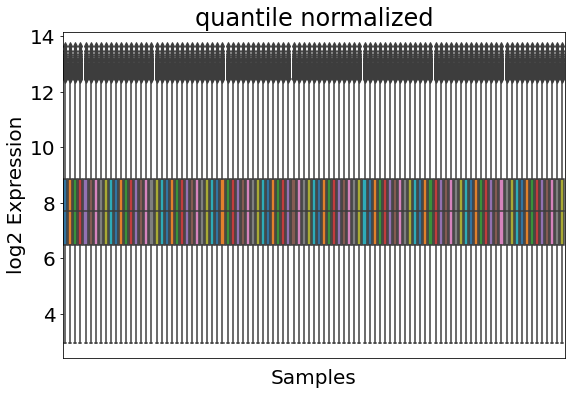

In [17]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:100], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

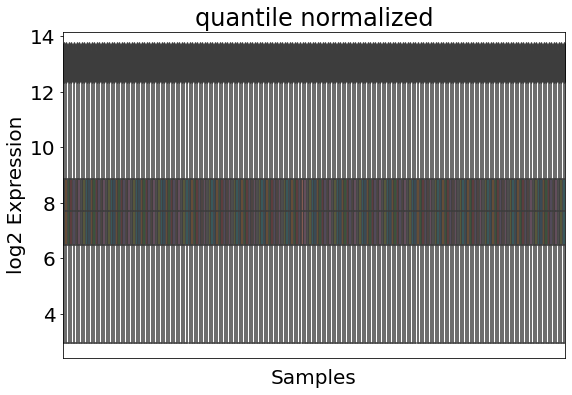

In [18]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 2000:2200], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

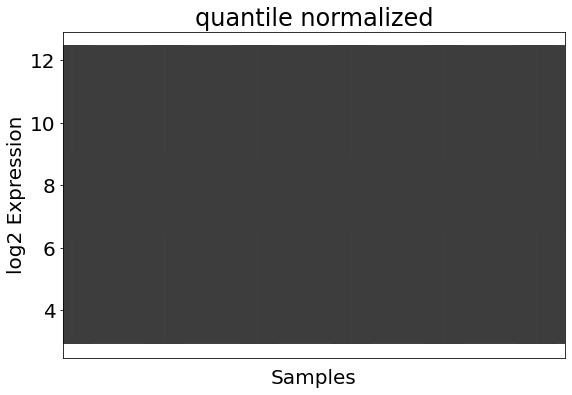

In [19]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:1000], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

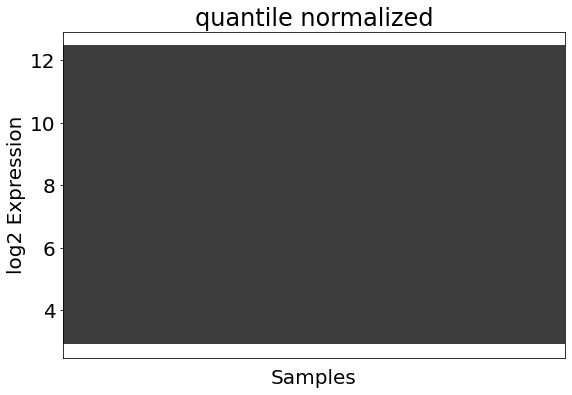

In [20]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.iloc[:, 1:expression.shape[1]], palette='tab10', showfliers=False)
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression', title='quantile normalized')
matplotlib.pyplot.show()

# 3. dimensionality reduction

In [15]:
transpose_expression_qn = expression_qn.transpose()
transpose_expression_qn.head()

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
E-GEOD-30169_GSM752709.cel,6.674178,9.253471,4.348688,6.547967,8.226402,7.877847,5.749067,6.206224,10.636120,9.778866,...,10.163430,11.088139,8.392577,10.538061,7.682210,9.836996,5.061649,6.168413,6.018051,6.700115
E-GEOD-30169_GSM752710.cel,6.962708,9.450826,4.065701,6.769329,8.032836,7.895058,5.468747,6.288019,10.499423,9.397884,...,10.099152,11.525933,8.771970,10.807247,7.391308,9.823300,4.774275,5.997441,5.814616,6.052927
E-GEOD-30169_GSM752711.cel,6.274973,9.358252,4.198858,6.382631,8.411676,7.915058,6.250226,5.814616,10.653945,9.897394,...,10.110796,11.266447,8.381983,10.480788,7.975027,9.895337,4.552457,6.131025,6.048658,6.539920
E-GEOD-30169_GSM752712.cel,6.483298,9.347803,4.587900,6.334080,8.095503,8.000321,5.698585,5.916943,10.664650,9.821316,...,10.108416,11.124328,8.410712,10.373180,7.771491,9.835031,5.103788,6.311302,5.820957,6.340377
E-GEOD-30169_GSM752713.cel,7.144404,10.134623,4.490600,6.621219,8.016995,7.993288,5.666206,5.893772,10.632673,9.643835,...,10.120252,9.938836,8.628687,10.437714,7.318389,9.726615,4.523678,5.617235,6.151873,6.190025


## 3.1. tSNE

In [22]:
# testing_perplexity = numpy.linspace(5, 50, 25)
# testing_perplexity

In [23]:
# testing_early_exaggeration = numpy.linspace(5, 20, 15)
# testing_early_exaggeration

CPU times: user 1min 2s, sys: 995 ms, total: 1min 3s
Wall time: 12.5 s


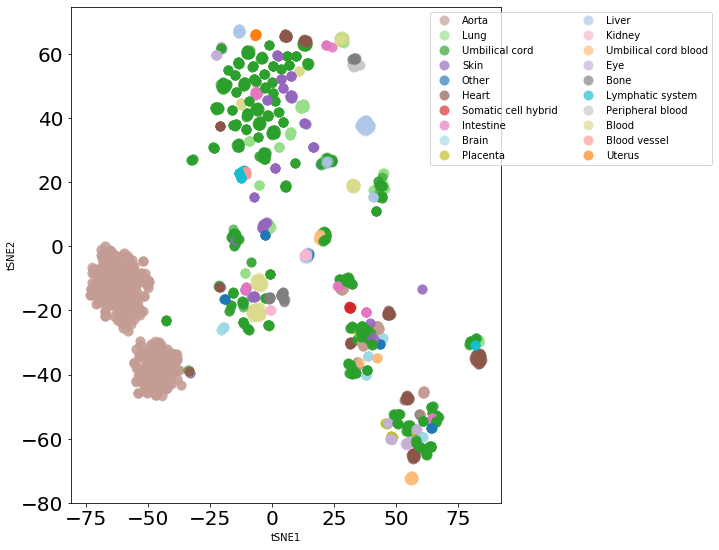

In [17]:
%%time

embedded = sklearn.manifold.TSNE(perplexity=45, init='pca', random_state=9).fit_transform(transpose_expression_qn)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    tissue = tissues_of_origin[i]

    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
        tagged_tissue.append(tissue)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout(pad=2)
#matplotlib.pyplot.savefig('figures/tsne.{}.pdf'.format(working_parameter))

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 2636 samples in 0.009s...
[t-SNE] Computed neighbors for 2636 samples in 0.410s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2636
[t-SNE] Computed conditional probabilities for sample 2000 / 2636
[t-SNE] Computed conditional probabilities for sample 2636 / 2636
[t-SNE] Mean sigma: 10.878184
[t-SNE] Computed conditional probabilities in 0.177s
[t-SNE] Iteration 50: error = 68.7069244, gradient norm = 0.0749025 (50 iterations in 0.558s)
[t-SNE] Iteration 100: error = 59.7208405, gradient norm = 0.0141271 (50 iterations in 0.448s)
[t-SNE] Iteration 150: error = 58.4698257, gradient norm = 0.0119240 (50 iterations in 0.422s)
[t-SNE] Iteration 200: error = 57.9900322, gradient norm = 0.0088336 (50 iterations in 0.416s)
[t-SNE] Iteration 250: error = 57.7266884, gradient norm = 0.0034191 (50 iterations in 0.441s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.726688
[t-SNE] Iteration 300: er

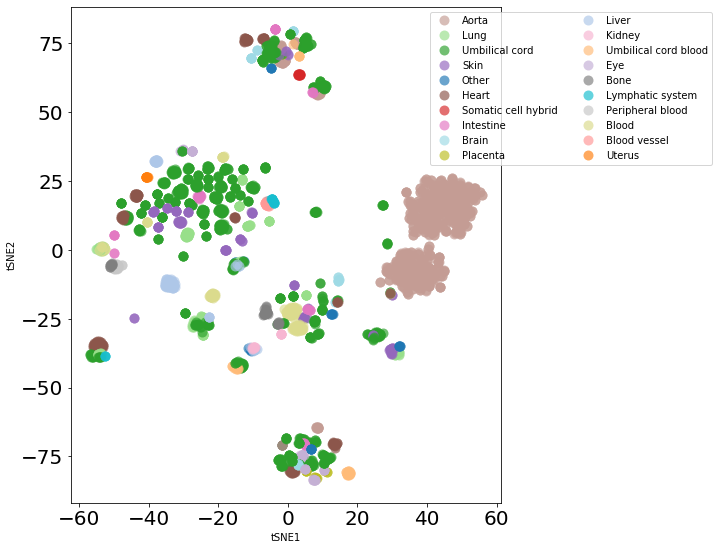

In [34]:
%%time


embedded = sklearn.manifold.TSNE(learning_rate=150,n_iter=2000,perplexity=60, random_state=0, verbose=2).fit_transform(transpose_expression_qn)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    tissue = tissues_of_origin[i]

    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
        tagged_tissue.append(tissue)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout(pad=2)
matplotlib.pyplot.savefig('figures_tsne.pdf')


## 3.2. UMAP

In [25]:
# testing_values = numpy.linspace(25, 300, 25).astype('int')
# testing_values

CPU times: user 13min 27s, sys: 4.3 s, total: 13min 32s
Wall time: 10min 40s


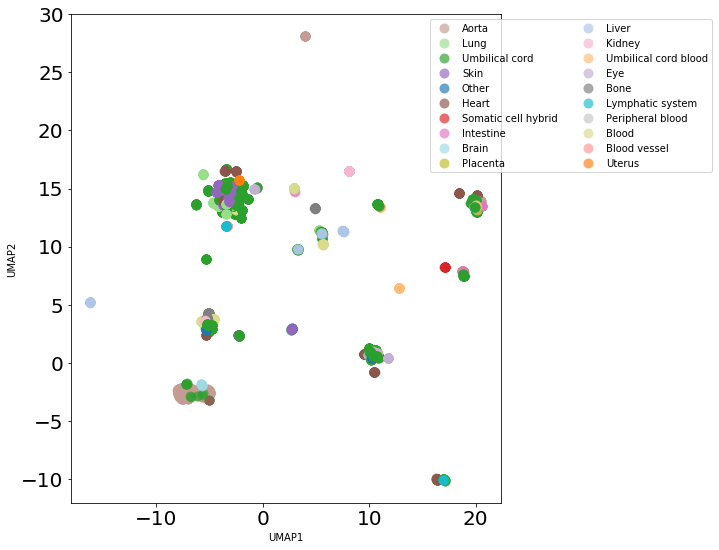

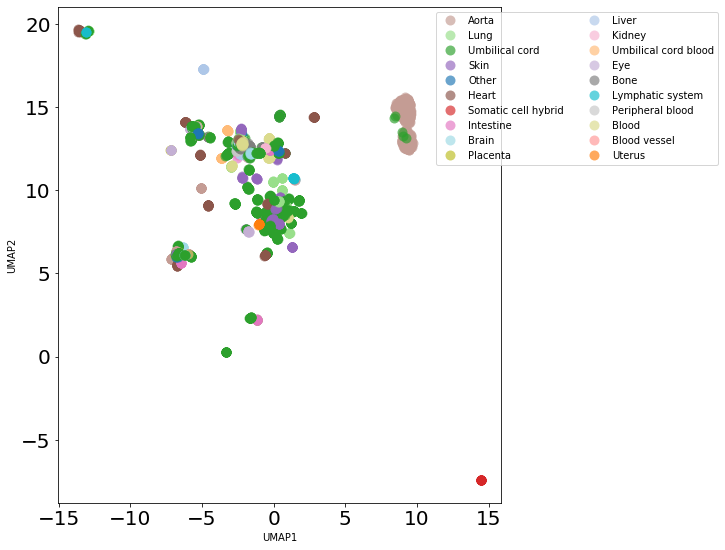

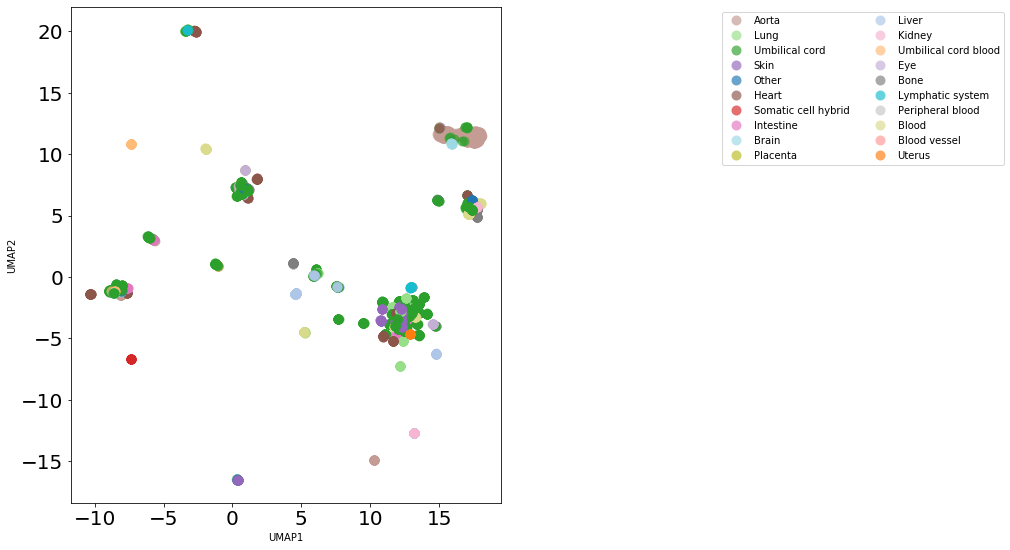

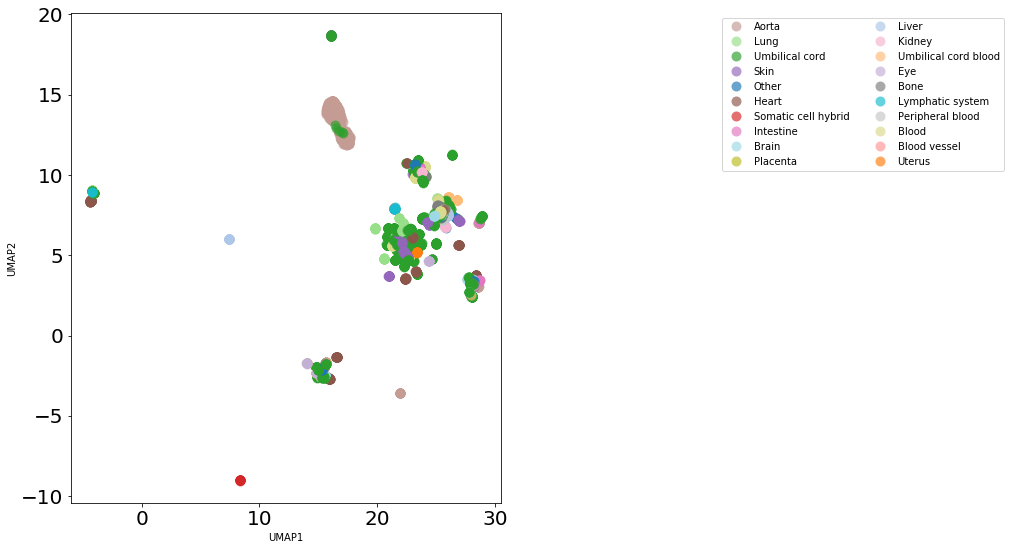

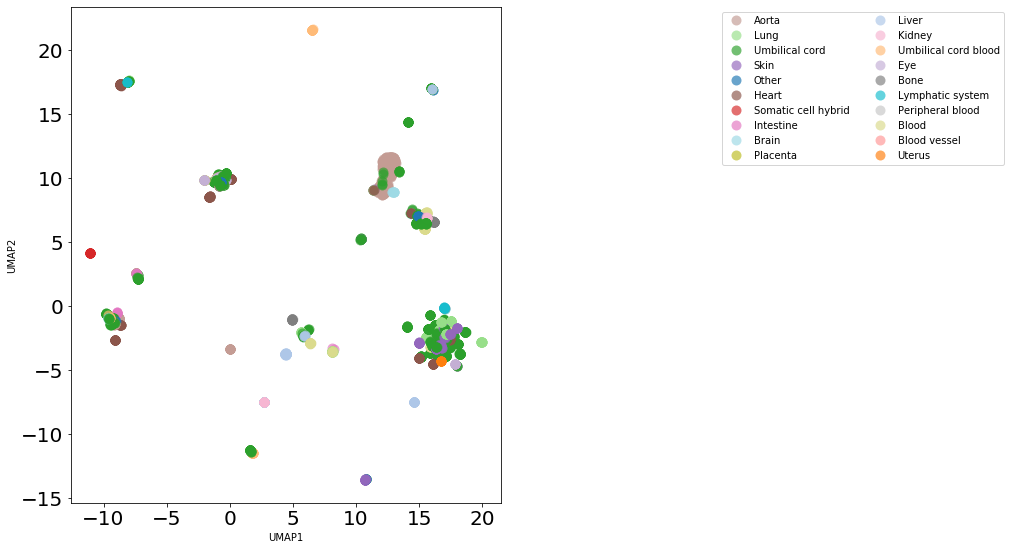

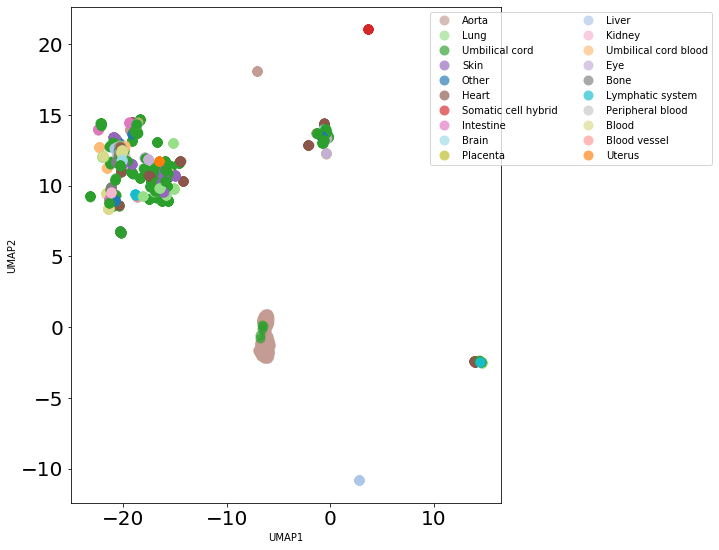

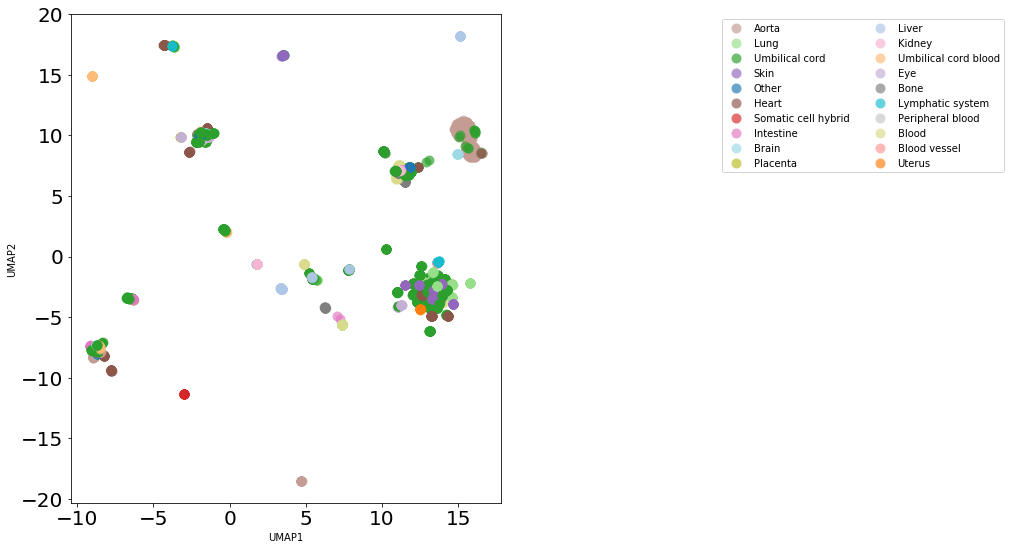

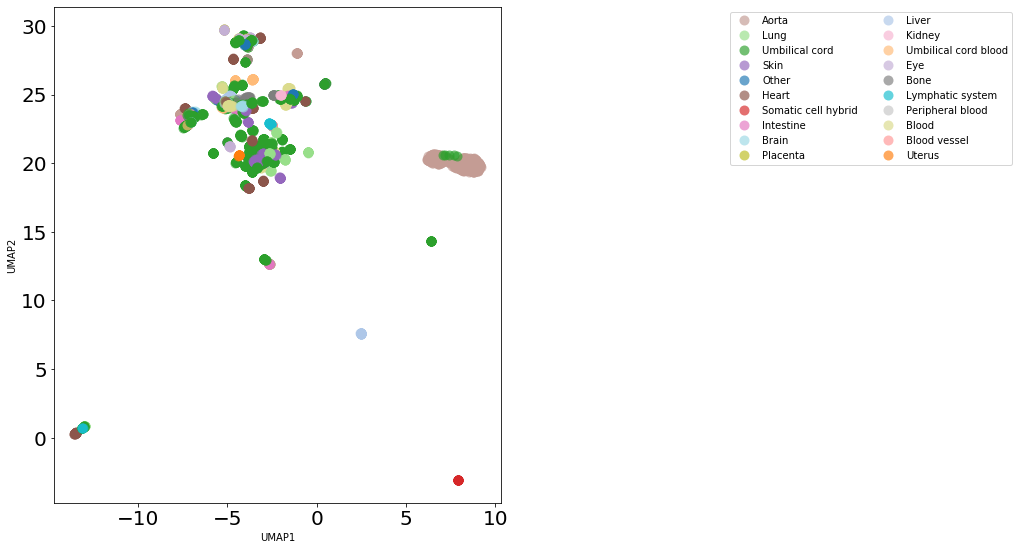

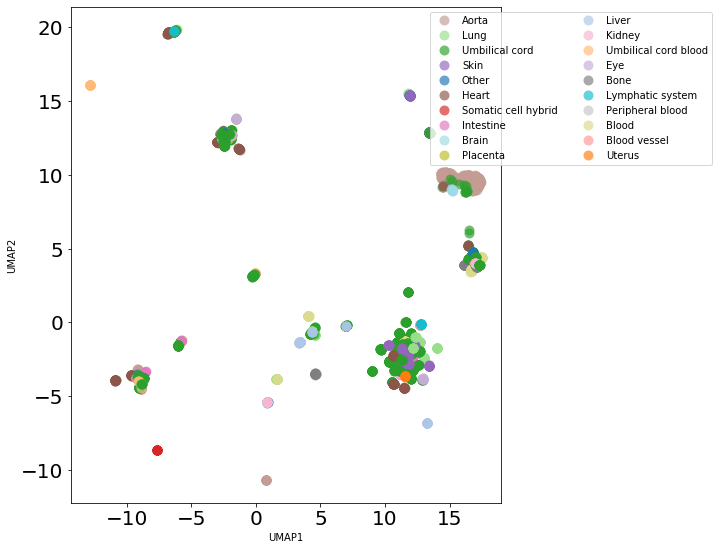

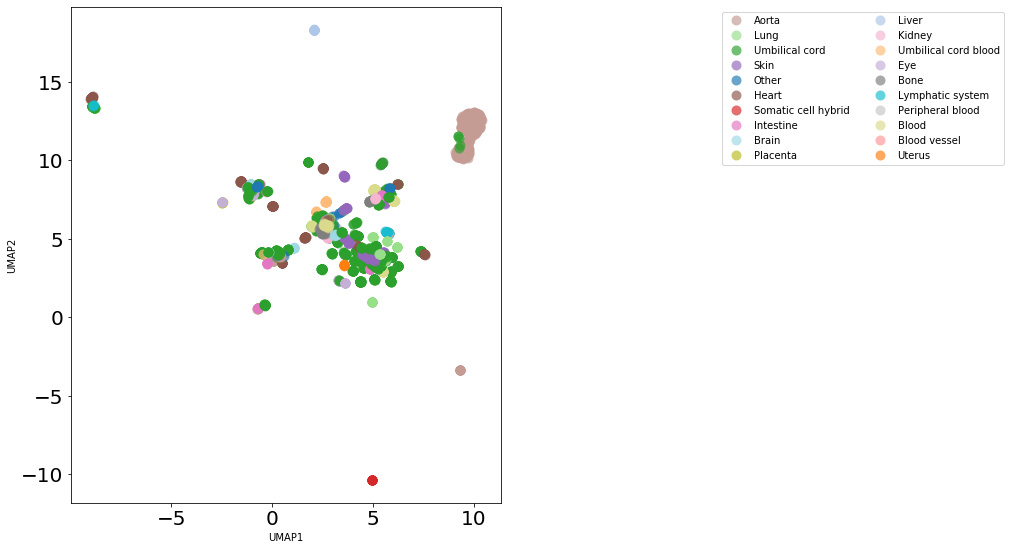

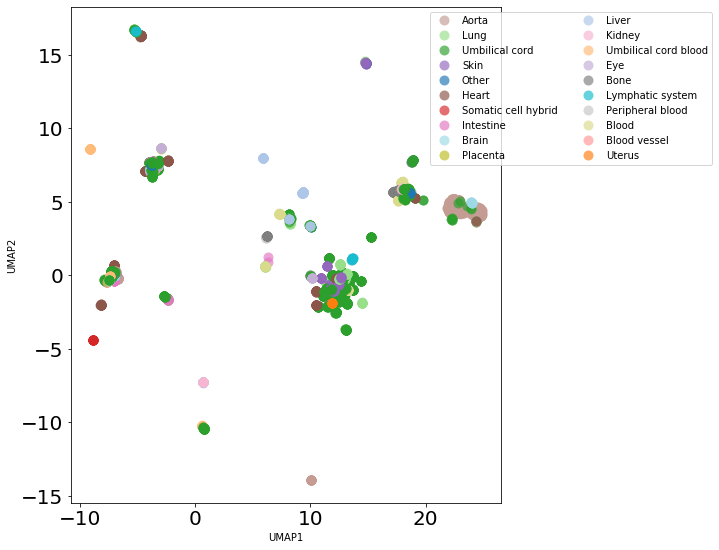

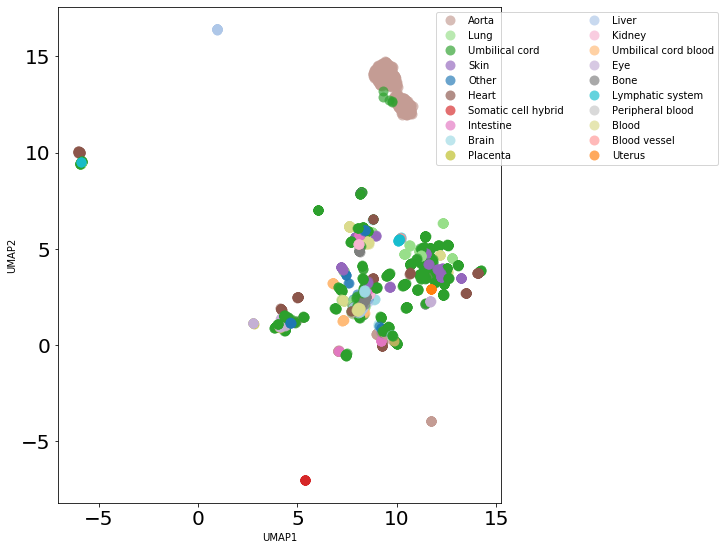

In [35]:
%%time
for t in range(240,300,10):
    for j in ['cosine','correlation']:
            embedded = umap.UMAP(n_neighbors=t, min_dist=0, metric=j).fit_transform(transpose_expression_qn)
            matplotlib.pyplot.figure(figsize=(12, 8))
            tagged_tissue = []
            for i in range(len(embedded)):
                x = embedded[i, 0]
                y = embedded[i, 1]
                tissue = tissues_of_origin[i]
                if tissue not in tagged_tissue:
                    matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
                    tagged_tissue.append(tissue)
                else:
                    matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)
            matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
            matplotlib.pyplot.xlabel('UMAP1')
            matplotlib.pyplot.ylabel('UMAP2')
            matplotlib.pyplot.tight_layout(pad=2)
            matplotlib.pyplot.savefig(f'figures_umap{t,j}.pdf')

CPU times: user 1min, sys: 626 ms, total: 1min
Wall time: 48.9 s


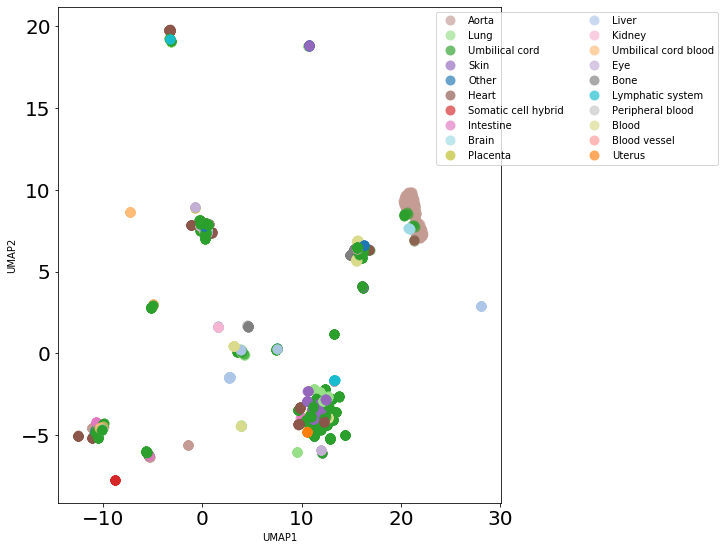

In [54]:
%%time

embedded = umap.UMAP(n_neighbors=250, min_dist=0, metric='cosine').fit_transform(transpose_expression_qn)
matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []
for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    tissue = tissues_of_origin[i]
    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0, label=tissue)
        tagged_tissue.append(tissue)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)
        
matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('UMAP1')
matplotlib.pyplot.ylabel('UMAP2')
matplotlib.pyplot.tight_layout(pad=2)
matplotlib.pyplot.savefig('figures_umap(252,correlation).pdf')

## 3.3 PCA

In [36]:
scaled_data=sklearn.preprocessing.scale(transpose_expression_qn)

In [37]:
pca=PCA(n_components=2)

In [38]:
pca.fit(scaled_data)

PCA(n_components=2)

In [39]:
pca_data=pca.transform(scaled_data)

In [40]:
per_var=numpy.round(pca.explained_variance_ratio_*100,decimals=1)
labels=['Pc'+ str(x) for x in range(1,len(per_var)+1)]

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


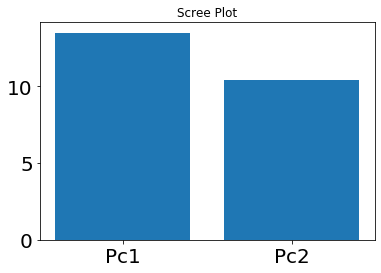

In [41]:
matplotlib.pyplot.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labels)
matplotlib.pyplot.title("Scree Plot")
matplotlib.pyplot.show()

In [42]:
principalDf = pandas.DataFrame(data = pca_data, columns = ['principal component 1', 'principal component 2'])

In [43]:
principalDf['Organ']=tissues_of_origin

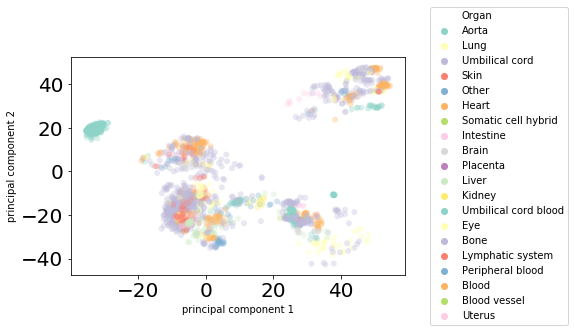

<Figure size 432x288 with 0 Axes>

In [44]:
g=seaborn.scatterplot('principal component 1', 'principal component 2',data=principalDf, hue="Organ", palette="Set3",linewidth=0, alpha=1/3)
g.legend(loc='right', bbox_to_anchor=(1.5, .5), ncol=1, fontsize=10)
matplotlib.pyplot.show()
matplotlib.pyplot.savefig(f'figures_PCA.pdf')

# 4. CV analysis

In [27]:
expression_qn.head()

,GSM752709.cel,GSM752710.cel,GSM752711.cel,GSM752712.cel,GSM752713.cel,GSM752714.cel,GSM752715.cel,GSM752716.cel,GSM752717.cel,GSM752718.cel,...,GSM46386.CEL,GSM46387.CEL,GSM46388.CEL,GSM46389.CEL,GSM46390.CEL,GSM46391.CEL,GSM46392.CEL,GSM46393.CEL,GSM46394.CEL,GSM46395.CEL
100,6.674178,6.962708,6.274973,6.483298,7.144404,7.220788,6.923905,6.937810,6.846293,7.152750,...,6.293228,6.534239,6.578697,6.742912,6.641251,6.680690,8.518564,8.018708,6.803907,6.682831
1000,9.253471,9.450826,9.358252,9.347803,10.134623,10.033171,10.268073,10.231386,10.643337,10.611442,...,9.374838,9.461932,9.981047,10.017765,9.875008,9.453999,9.576691,9.295847,9.149958,9.063993
10000,4.348688,4.065701,4.198858,4.587900,4.490600,4.486824,4.213578,4.183800,4.448572,4.594608,...,6.503164,6.500804,6.392547,6.857464,6.286730,6.499627,6.873678,6.888788,6.915876,6.956745
10005,6.547967,6.769329,6.382631,6.334080,6.621219,6.828782,6.701218,6.633548,6.520506,6.726995,...,7.586550,7.861450,7.501221,7.523943,7.382496,6.627876,7.248987,7.602272,7.653583,8.183978
10006,8.226402,8.032836,8.411676,8.095503,8.016995,7.860594,8.189388,7.952356,8.112309,7.932339,...,6.550235,6.309996,5.912284,5.608274,6.615719,6.180599,6.026818,6.890802,5.363720,6.268397


In [28]:
expression_statistics = pandas.DataFrame(expression_qn.mean(axis=1).to_dict(), index=['mean']).transpose()
deviations = expression_qn.std(axis=1).to_dict()
expression_statistics['std'] = pandas.Series(deviations)
expression_statistics['CV'] = expression_statistics['std'] / expression_statistics['mean']
expression_statistics

,mean,std,CV
100,7.711900,1.045379,0.135554
1000,8.745869,1.629556,0.186323
10000,6.090182,1.660054,0.272579
10005,6.336139,1.062841,0.167743
10006,7.646740,1.425574,0.186429
...,...,...,...
9989,9.409202,0.859925,0.091392
9990,5.858157,1.337978,0.228396
9991,7.305720,1.678291,0.229723
9993,6.804256,1.047933,0.154011


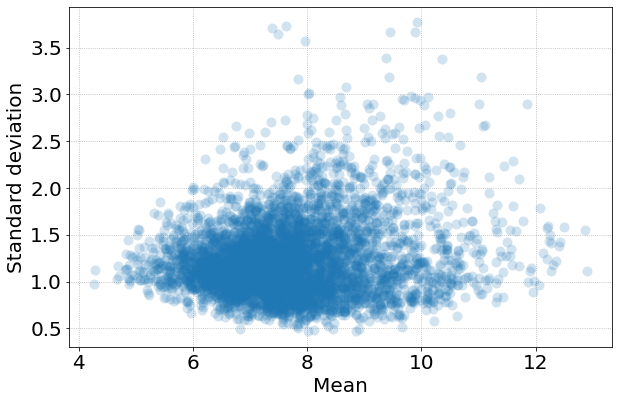

In [29]:
matplotlib.pyplot.figure(figsize=(9, 6))
matplotlib.pyplot.plot(expression_statistics['mean'], expression_statistics['std'], 'o', alpha=1/5, ms=10, mew=0)
matplotlib.pyplot.xlabel('Mean')
matplotlib.pyplot.ylabel('Standard deviation')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

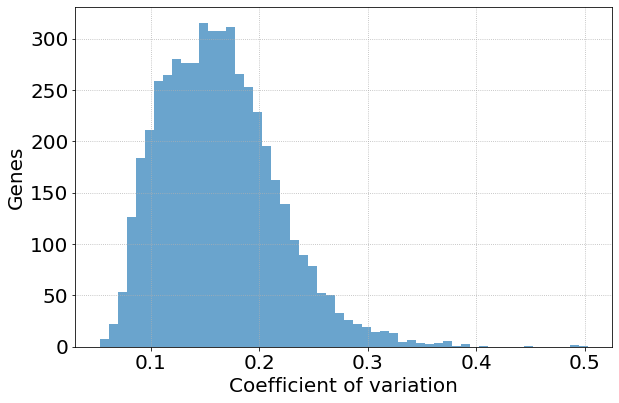

In [30]:
matplotlib.pyplot.figure(figsize=(9, 6))
tempo = matplotlib.pyplot.hist(expression_statistics['CV'].values, bins='auto', density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Coefficient of variation')
matplotlib.pyplot.ylabel('Genes')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

In [31]:
# consider plotting the expression profile for the top and bottom CV genes

# 5. Shannon entropy analysis

We are going to remove the genes that have less disorder in their expression. 

In [15]:
def Entropy(L):
    return entropy(L,base=2)

# first example 

In [18]:
A_List_For_Test0=[1,1,1,1,1]

In [20]:
Entropy(pandas.Series(A_List_For_Test0).value_counts())

0.0

In [21]:
A_List_For_Test1=[1,1,1,1,2]

In [22]:
Entropy(pandas.Series(A_List_For_Test1).value_counts())

0.7219280948873623

In [23]:
A_List_For_Test2=[1,1,1,2,2]

In [24]:
Entropy(pandas.Series(A_List_For_Test2).value_counts())

0.9709505944546688

# second example

In this example, we take 3 lists a,b,c of randomly with the normal distribution of 100 elements with mean 1,30, and 15 with standard deviation 1,1, and 10, respectively. We clime that, if Min and Max be the universal min and max for these three lists then Entropy of a and b will be the same and small and smaller than Entropy of c.

In [2]:
a=numpy.random.normal(1,1,100)

In [3]:
a

array([-2.24460845e-01, -1.42011214e+00, -3.67273857e-03,  4.94718341e-01,
        7.47116670e-01, -2.19345000e-01,  4.06050498e+00,  2.55450659e+00,
        1.16731828e+00,  1.52183929e+00,  1.65487625e+00,  8.92891389e-01,
        4.81960563e-01,  2.22925579e+00, -4.75141341e-01,  2.11233020e+00,
        3.05248597e+00,  2.45190953e+00,  1.04249307e+00,  2.12241124e+00,
        1.21017911e+00,  1.46794926e+00, -1.09725347e+00,  8.35891569e-01,
       -1.58665761e-01,  9.13099077e-01,  2.77879375e-01,  1.43875155e+00,
        3.33912734e+00,  2.61546776e+00,  1.19344515e+00,  8.94092972e-02,
        1.29713586e+00,  1.94512268e+00,  1.73178512e+00,  1.30830607e+00,
        1.32042721e+00, -4.40027725e-01,  2.34187215e+00, -3.02751090e-01,
        2.63051588e+00,  6.18784199e-01,  1.27071644e+00,  1.86940164e+00,
        5.28905894e-01,  1.29365234e+00,  1.18911095e+00,  1.51122748e+00,
        1.06280330e+00,  1.79374898e+00,  2.41025545e+00, -6.72921695e-02,
        1.92221503e+00,  

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


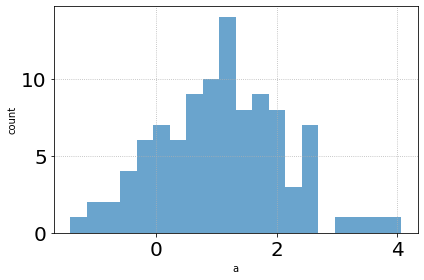

In [4]:
matplotlib.pyplot.figure(figsize=(6, 4))
tempo = matplotlib.pyplot.hist(a, bins=20, density=False, alpha=2/3)
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.xlabel('a')
matplotlib.pyplot.ylabel('count')
matplotlib.pyplot.tight_layout()

If we splet the range of data into n interval by histegram we can show how many elements are in each interval.

In [70]:
b=numpy.random.normal(30,1,100)

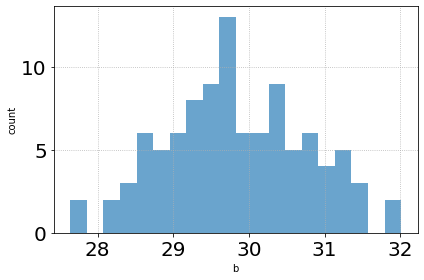

In [71]:
matplotlib.pyplot.figure(figsize=(6, 4))
tempo = matplotlib.pyplot.hist(b, bins=20, density=False, alpha=2/3)
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.xlabel('b')
matplotlib.pyplot.ylabel('count')
matplotlib.pyplot.tight_layout()

In [72]:
c=numpy.random.normal(15,10,100)

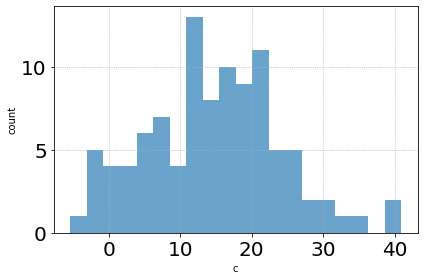

In [73]:
matplotlib.pyplot.figure(figsize=(6, 4))
tempo = matplotlib.pyplot.hist(c, bins=20, density=False, alpha=2/3)
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.xlabel('c')
matplotlib.pyplot.ylabel('count')
matplotlib.pyplot.tight_layout()

In [74]:
Min=min([min(a),min(b),min(c)])
Min

-5.395528188246299

In [75]:
Max=max([max(a),max(b),max(c)])
Max

40.91814246312071

In [76]:
# chunking an interval into n pices(groups)  
def chunks1(lst,n):
    EnL=[]
    d=(Max-Min)/n
    for i in range(0, n-1):
        for j in lst:
            if Min+i*d<= j<Min+i*d+d:
                EnL.append(i)
    return EnL

In [77]:
pandas.Series(chunks1(a,20)).value_counts()

2    63
3    33
1     4
dtype: int64

In [78]:
pandas.Series(chunks1(b,20)).value_counts()

15    66
14    32
16     2
dtype: int64

In [79]:
pandas.Series(chunks1(c,20)).value_counts()

7     13
11    11
9     10
10     9
8      8
5      7
4      6
13     5
12     5
1      5
2      4
6      4
3      4
15     2
14     2
17     1
16     1
0      1
dtype: int64

In [80]:
[Entropy(pandas.Series(chunks1(a,20)).value_counts()),Entropy(pandas.Series(chunks1(b,20)).value_counts()),Entropy(pandas.Series(chunks1(c,20)).value_counts())]

[1.1335197785814877, 1.0345560709981454, 3.8606460585566413]

Back to main proplem 

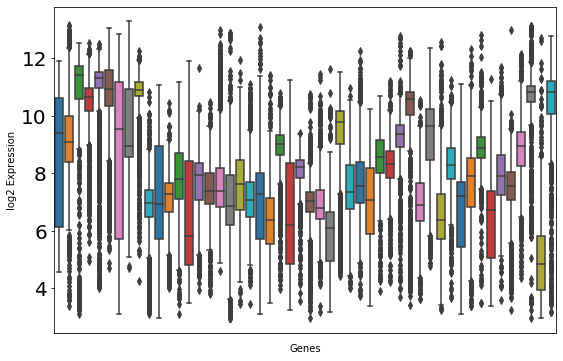

In [38]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = seaborn.boxplot(data=expression_qn.T.iloc[:, 600:650], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Genes', ylabel='log2 Expression')
matplotlib.pyplot.show()

 By histogram we check the disterbution of each gene in its interval. Since we splite an interval into 100 part and 2ˆ6=64<100<2ˆ7=128 then we expect to have Entropy around 6. If a histugram tondes to show a flat figure then it says more disorderity or biger Entropy.

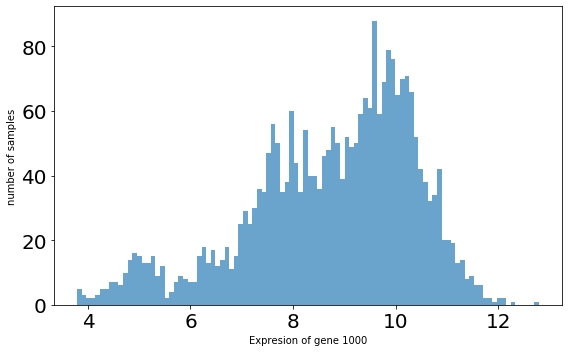

In [56]:
matplotlib.pyplot.figure(figsize=(8, 5))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,1], bins=100, density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Expresion of gene 1000')
matplotlib.pyplot.ylabel('number of samples')
matplotlib.pyplot.tight_layout()

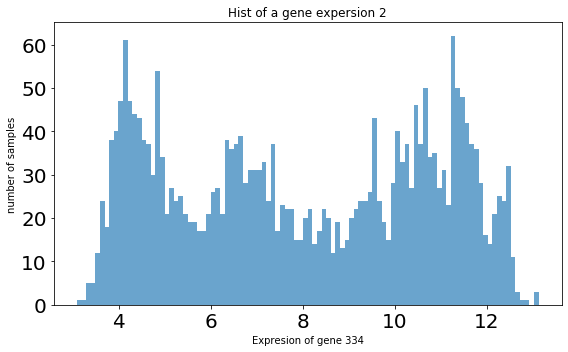

In [140]:
matplotlib.pyplot.figure(figsize=(8, 5))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,1772], bins=100, density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Expresion of gene 334')
matplotlib.pyplot.ylabel('number of samples')
matplotlib.pyplot.title('Hist of a gene expersion 2')
matplotlib.pyplot.tight_layout()

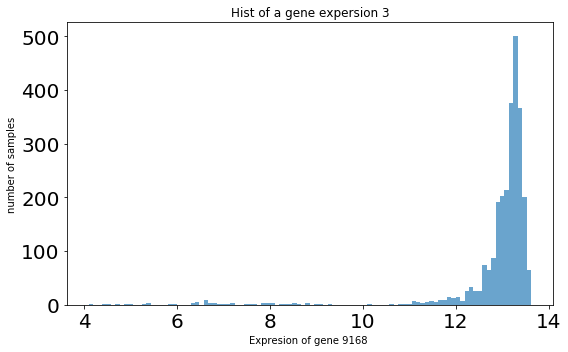

In [141]:
matplotlib.pyplot.figure(figsize=(8, 5))
tempo = matplotlib.pyplot.hist(transpose_expression_qn.iloc[:,4644], bins=100, density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Expresion of gene 9168 ')
matplotlib.pyplot.ylabel('number of samples')
matplotlib.pyplot.title('Hist of a gene expersion 3')
matplotlib.pyplot.tight_layout()

First case, in this case we consider the max and min of each genes.

In [132]:
# chunking an interval into 100 pices(groups)  
Min=min([min(transpose_expression_qn.iloc[:,i]) for i in range(0,4998)])
Max=max([max(transpose_expression_qn.iloc[:,i]) for i in range(0,4998)])

def chunks(lst):
    EnL=[]
    d=(Max-Min)/100
    for i in range(0, 99):
        for j in lst:
            if Min+i*d<= j<Min+i*d+d:
                EnL.append(i)
    return EnL

In [143]:
ENC=[chunks(transpose_expression_qn.iloc[:,i]) for i in range(0,4998)]

In [144]:
expression_entropy=[Entropy(pandas.Series(ENC[i]).value_counts()) for i in range(0,4998)]

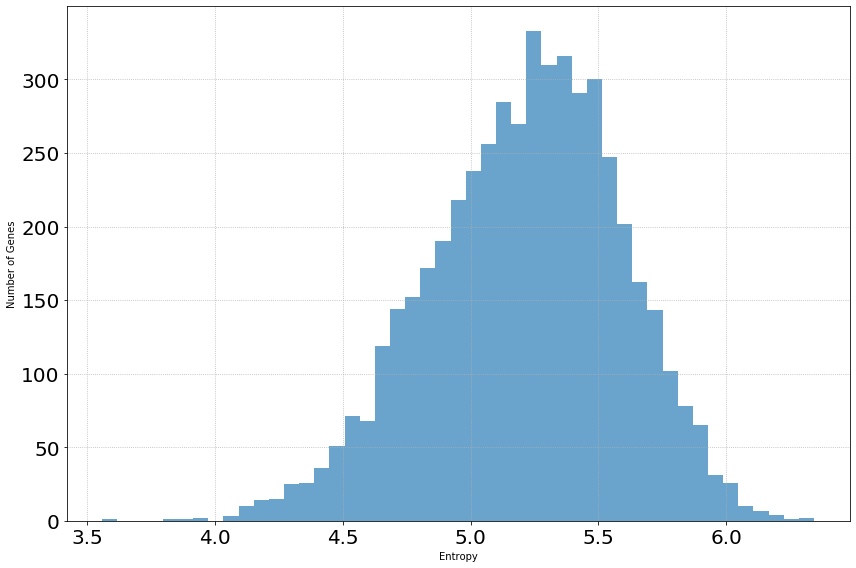

In [145]:
matplotlib.pyplot.figure(figsize=(12, 8))
tempo = matplotlib.pyplot.hist(expression_entropy, bins='auto', density=False, alpha=2/3)
matplotlib.pyplot.xlabel('Entropy')
matplotlib.pyplot.ylabel('Number of Genes')
matplotlib.pyplot.grid(0.5, ls=':')
matplotlib.pyplot.tight_layout()

Since there are some genes that are distributed almost in a small port of universal interval so they have minimum entropy, see 'Hist of a gene expression 3'. On the other hand, there are some other genes that are distributed in whole universal interval almost uniformly, thus they have bigger entropy, see 'Hist of a gene expression 2'. In conclusion, the entropy of each gene depends on the size of their interval of expression how they are distributed so we expect to have a normal distribution of entropy of genes. Note that, the universal interval is divided into 100 parts so if a gene expression is distributed almost uniformly in this interval then entropy would be less than <7=log_2 100.

In [55]:
transpose_expression_qn

,100,1000,10000,10005,10006,10007,10010,10013,10015,10019,...,9978,998,9984,9987,9988,9989,9990,9991,9993,9994
GSM752709.cel,6.674178,9.253471,4.348688,6.547967,8.226402,7.877847,5.749067,6.206224,10.636120,9.778866,...,10.163430,11.088139,8.392577,10.538061,7.682210,9.836996,5.061649,6.168413,6.018051,6.700115
GSM752710.cel,6.962708,9.450826,4.065701,6.769329,8.032836,7.895058,5.468747,6.288019,10.499423,9.397884,...,10.099152,11.525933,8.771970,10.807247,7.391308,9.823300,4.774275,5.997441,5.814616,6.052927
GSM752711.cel,6.274973,9.358252,4.198858,6.382631,8.411676,7.915058,6.250226,5.814616,10.653945,9.897394,...,10.110796,11.266447,8.381983,10.480788,7.975027,9.895337,4.552457,6.131025,6.048658,6.539920
GSM752712.cel,6.483298,9.347803,4.587900,6.334080,8.095503,8.000321,5.698585,5.916943,10.664650,9.821316,...,10.108416,11.124328,8.410712,10.373180,7.771491,9.835031,5.103788,6.311302,5.820957,6.340377
GSM752713.cel,7.144404,10.134623,4.490600,6.621219,8.016995,7.993288,5.666206,5.893772,10.632673,9.643835,...,10.120252,9.938836,8.628687,10.437714,7.318389,9.726615,4.523678,5.617235,6.151873,6.190025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM46391.CEL,6.680690,9.453999,6.499627,6.627876,6.180599,8.156127,8.002077,3.926047,9.949225,9.066524,...,9.553343,9.286946,6.693650,7.136856,7.307607,9.162135,7.481852,6.931807,6.728105,5.177980
GSM46392.CEL,8.518564,9.576691,6.873678,7.248987,6.026818,8.344868,6.330215,3.828148,10.521753,9.061417,...,9.700683,9.883105,7.502107,7.723830,6.247563,9.662931,5.923257,5.559335,7.483610,4.996755
GSM46393.CEL,8.018708,9.295847,6.888788,7.602272,6.890802,8.352442,6.521645,3.677526,10.594286,9.061417,...,9.335781,9.364305,7.330966,7.748127,6.138085,9.416360,6.045787,5.618993,6.947835,4.902132
GSM46394.CEL,6.803907,9.149958,6.915876,7.653583,5.363720,7.855389,9.492671,4.853739,8.709402,8.553834,...,7.991517,10.966986,8.445566,4.899453,7.866683,8.352442,9.370323,8.075894,7.952356,5.234050


In [107]:
expression_entropy.sort()

In [108]:
expression_entropy[4898:]

[5.911984753415139,
 5.913252122832309,
 5.913833967097539,
 5.914491875508409,
 5.914520118406879,
 5.914525836576799,
 5.914681278862678,
 5.9168259948799,
 5.918396717074834,
 5.919492703479904,
 5.920377290713757,
 5.920910310221291,
 5.921844407921257,
 5.922037642245388,
 5.92330065748441,
 5.923898514385959,
 5.924270911688402,
 5.92531508179551,
 5.925875625770912,
 5.93086494108755,
 5.931196325332798,
 5.932791839093331,
 5.934867212967122,
 5.935424113422025,
 5.938474178753715,
 5.938663439987616,
 5.93872485568698,
 5.938850899981226,
 5.938955196269083,
 5.939309761149436,
 5.940865754730854,
 5.943308285887243,
 5.9470270630672735,
 5.947362957695758,
 5.9509536990635565,
 5.954255078827967,
 5.956482336812514,
 5.957146575653034,
 5.958376512516648,
 5.96076775074993,
 5.961280815739213,
 5.965888232687133,
 5.966630995573916,
 5.9712666269426835,
 5.976174514267867,
 5.979071644735378,
 5.984146469012523,
 5.984272988855596,
 5.984764074252456,
 5.987316706667887,
 5.9

In [88]:
List_of_index_genes_with_most_EN=[]
for i in range(0,4998):
    if expression_entropy[i]>=5.911984753415139:
        List_of_index_genes_with_most_EN.append(i)
    

In [89]:
transpose_expression_qn.iloc[:,List_of_index_genes_with_most_EN]

,10150,10221,10342,10395,10643,10730,10787,11051,1282,1295,...,8519,8743,8848,8878,8905,8992,9289,960,9768,998
GSM752709.cel,7.287779,4.621586,5.016274,4.452379,7.502107,4.059819,5.101576,7.757714,7.298639,4.327457,...,7.345231,8.639090,9.183945,5.772159,10.294876,6.271091,6.026818,6.871673,7.774104,11.088139
GSM752710.cel,6.825688,4.448572,4.996755,4.005792,7.376257,4.490600,4.158523,7.471323,7.207987,3.767487,...,6.934830,8.104322,8.712668,5.817809,10.127395,5.822574,5.717299,6.943809,7.459901,11.525933
GSM752711.cel,7.610037,4.886104,5.021021,4.490600,7.626577,4.218409,5.257428,7.523943,7.418582,4.301301,...,7.135890,7.334538,9.069092,7.370038,10.028692,6.713024,6.034167,7.006531,7.564947,11.266447
GSM752712.cel,7.518718,5.021021,4.756685,4.570267,7.605716,3.844252,5.622479,7.344375,7.472176,4.448572,...,7.111490,7.361224,9.107759,7.377139,10.244384,6.850382,6.098825,7.024777,7.479153,11.124328
GSM752713.cel,6.367799,4.878344,4.598003,5.712147,7.140686,4.501654,4.433143,7.044980,7.160173,3.164206,...,6.684960,8.593446,9.309030,6.297113,10.208343,5.971885,5.683300,7.803381,7.115251,9.938836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM46391.CEL,8.433024,7.703892,10.738073,8.841513,8.790764,8.736694,8.454371,7.770647,10.803248,4.018366,...,7.534468,8.277769,8.700714,11.390536,9.550037,10.791455,8.837018,6.243569,11.729149,9.286946
GSM46392.CEL,7.027711,8.287861,10.241717,7.819893,10.073677,8.231885,8.371459,7.867549,7.087953,3.644219,...,6.399932,4.839922,10.611442,9.099961,7.427432,10.843226,10.604573,10.564171,10.629051,9.883105
GSM46393.CEL,6.600151,8.400137,10.257417,7.925460,9.968416,8.313879,8.275907,7.974162,7.084096,3.785727,...,5.915405,4.705253,10.103722,9.379516,8.319476,10.843226,10.338865,10.364505,10.336038,9.364305
GSM46394.CEL,9.153980,7.816392,11.182915,8.609986,6.131025,6.864563,7.782761,7.547638,8.948432,4.153556,...,9.282547,8.022228,10.087453,8.907254,10.381822,10.515472,8.744391,5.349965,10.378931,10.966986


In [103]:
list_of__genes_with_most_EN=expression.reset_index()['index'][List_of_index_genes_with_most_EN]

In [104]:
list_of__genes_with_most_EN

60      10150
93      10221
151     10342
164     10395
290     10643
        ...  
4570     8992
4695     9289
4820      960
4894     9768
4989      998
Name: index, Length: 100, dtype: int64

In [124]:
expression_entropy.index(max(expression_entropy))

1772

In [139]:
transpose_expression_qn.iloc[:,4644:4646]

,9168,9169
GSM752709.cel,13.277834,8.697455
GSM752710.cel,13.452107,9.005450
GSM752711.cel,13.355640,8.799746
GSM752712.cel,13.277834,9.144625
GSM752713.cel,13.277834,9.000586
...,...,...
GSM46391.CEL,12.889522,7.121821
GSM46392.CEL,13.355640,7.336312
GSM46393.CEL,13.355640,7.143498
GSM46394.CEL,13.120000,8.060009
